# Titanic

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.learning_curve import validation_curve
import sknn.mlp
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import scipy.stats as stats
import requests

import os.path
import tempfile
import uuid
import random
import csv

In [2]:
pylab.rcParams['figure.figsize'] = (16, 12)  # that's default image size for this interactive session
plt.figure(figsize=(16, 12))
sns.set_style('whitegrid')

def plot_validation_curve(traning_scores, testing_scores, param_range, log=False, title=''):

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel('$\gamma$')
    plt.ylabel('Score')
    plt.ylim(0.0, 1.1)
    
    if log:
        plt.semilogx(param_range, train_scores_mean, label='Training score', color='r')
    else:
        plt.plot(param_range, train_scores_mean, label='Training score', color='r')
    
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='r')
    if log:
        plt.semilogx(param_range, test_scores_mean, label='Cross-validation score', color='g')
    else:
        plt.plot(param_range, test_scores_mean, label='Cross-validation score', color='g')
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color='g')
    plt.legend(loc='best')
    plt.show()

## Pre-processing Data

First, we clean off the data, by checking for missing values, and imputing them as necessary.

In [3]:
np.random.seed(7)

train_file = 'train.csv'
assess_file = 'test.csv'

In [4]:
source_df = pd.read_csv(train_file, header=0)
assess_df = pd.read_csv(assess_file, header=0)
composite_df = pd.concat([source_df, assess_df])

In [5]:
composite_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


Let's check the DataFrame for missing values

In [6]:
source_df.apply(lambda x: sum(pd.isnull(x)))

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
assess_df.apply(lambda x: sum(pd.isnull(x)))

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

From train.csv, at least two variables have missing values: Age, and Embarked. In the blind test, one entry of Fare, and 86 of Age also have missing values. The entry Cabin has several missing values, for most of the records, but since we won't using on our model, we need not worry about this.
Before choosing a strategy for imputing them, we look at the distribution of the variables Age, and Fare, starging with Age.

**Age**

In [8]:
for key, grp in composite_df.groupby(['Pclass']):    
    print('Class[{}]: Mode({}), Median({})'.format(key, grp.Age.dropna().mode()[0],grp.Age.dropna().median()))

for df in (source_df, assess_df):
    for key, grp in df.groupby(['Pclass']):    
        df.loc[(df.Age.isnull()) & (df.Pclass == key), 'Age'] = composite_df.loc[composite_df.Pclass == key, 'Age'].dropna().mode()[0]


Class[1]: Mode(36.0), Median(39.0)
Class[2]: Mode(24.0), Median(29.0)
Class[3]: Mode(22.0), Median(24.0)


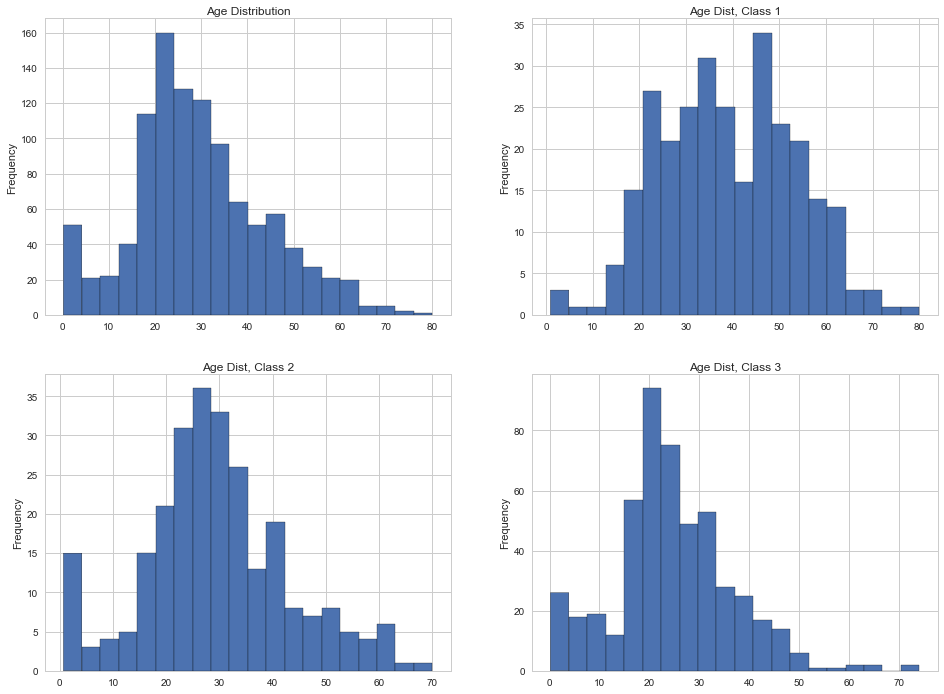

In [9]:
_, axes = plt.subplots(2, 2)
quadrant = [(0,0),(0,1),(1,0),(1,1)]

p = composite_df.Age.plot.hist(stacked=True, bins=20, ax=axes[0,0])
p.set_title('Age Distribution')

for idx, (key, grp) in enumerate(composite_df.groupby(['Pclass'])):
    p = grp.Age.plot.hist(stacked=False, bins=20, label=key, ax=axes[quadrant[idx+1][0], quadrant[idx+1][1]])
    p.set_title('Age Dist, Class {0}'.format(key))
plt.show()

Age has some missing values, and its distribution seems to vary by class, so to impute them we opt for using the median from each passenger class.

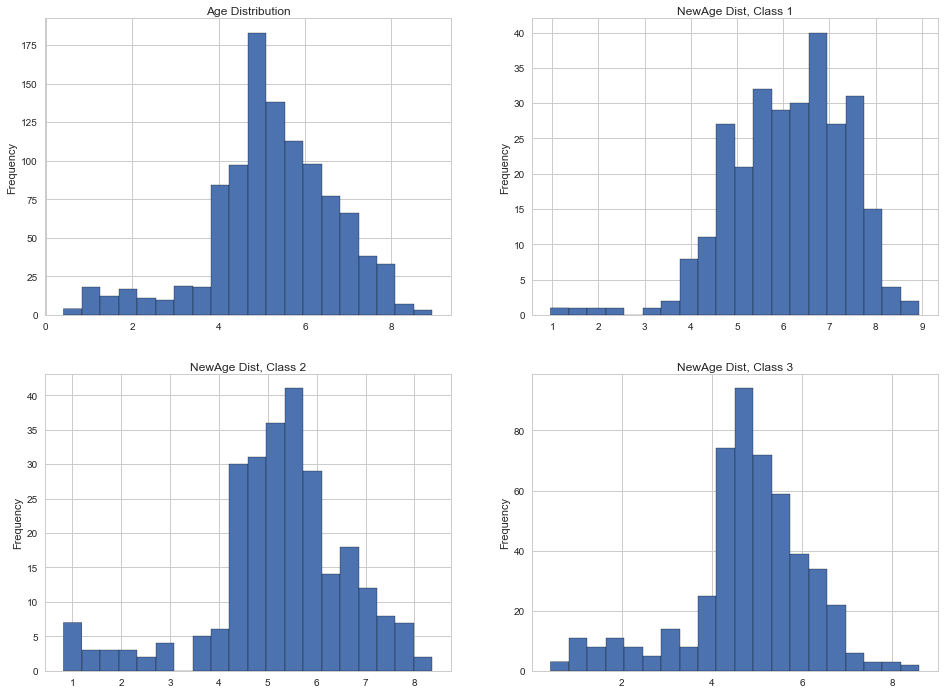

In [10]:
for df in (source_df, assess_df, composite_df):
    df['NewAge'] = df.Age.apply(lambda x: x**(0.5) if x else x)

_, axes = plt.subplots(2, 2)
quadrant = [(0,0),(0,1),(1,0),(1,1)]

p = composite_df.NewAge.plot.hist(stacked=True, bins=20, ax=axes[0,0])
p.set_title('Age Distribution')

for idx, (key, grp) in enumerate(composite_df.groupby(['Pclass'])):
    p = grp.NewAge.plot.hist(stacked=False, bins=20, label=key, ax=axes[quadrant[idx+1][0], quadrant[idx+1][1]])
    p.set_title('NewAge Dist, Class {0}'.format(key))
plt.show()

**Fare**

In [11]:
for key, grp in composite_df.groupby(['Pclass']):    
    print('Class[{}]: Mode({}), Median({})'.format(key, grp.Fare.dropna().mode()[0],grp.Fare.dropna().median()))

for df in (source_df, assess_df):
    for key, grp in df.groupby(['Pclass']):    
        df.loc[(df.Fare.isnull()) & (df.Pclass == key), 'Fare'] = composite_df.loc[composite_df.Pclass == key, 'Fare'].dropna().mode()[0]


Class[1]: Mode(26.55), Median(60.0)
Class[2]: Mode(13.0), Median(15.0458)
Class[3]: Mode(8.05), Median(8.05)


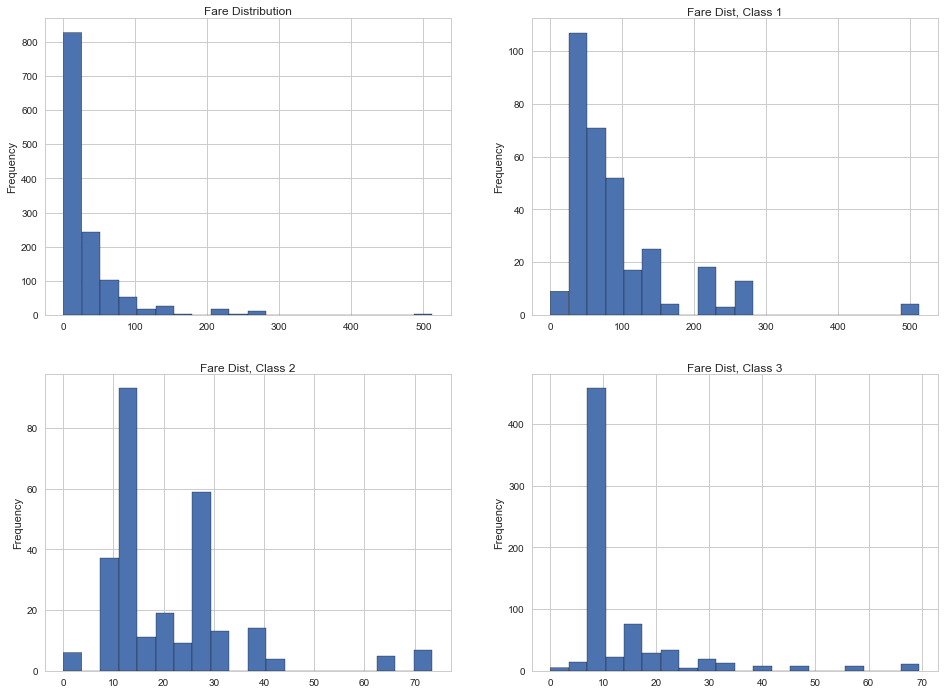

In [12]:
_, axes = plt.subplots(2, 2)
quadrant = [(0,0),(0,1),(1,0),(1,1)]

p = composite_df.Fare.plot.hist(stacked=True, bins=20, ax=axes[0,0])
p.set_title('Fare Distribution')

for idx, (key, grp) in enumerate(composite_df.groupby(['Pclass'])):
    p = grp.Fare.plot.hist(stacked=False, bins=20, label=key, ax=axes[quadrant[idx+1][0], quadrant[idx+1][1]])
    p.set_title('Fare Dist, Class {0}'.format(key))
plt.show()

Age has some missing values, and its distribution seems to vary by class, so to impute them we opt for using the median from each passenger class.

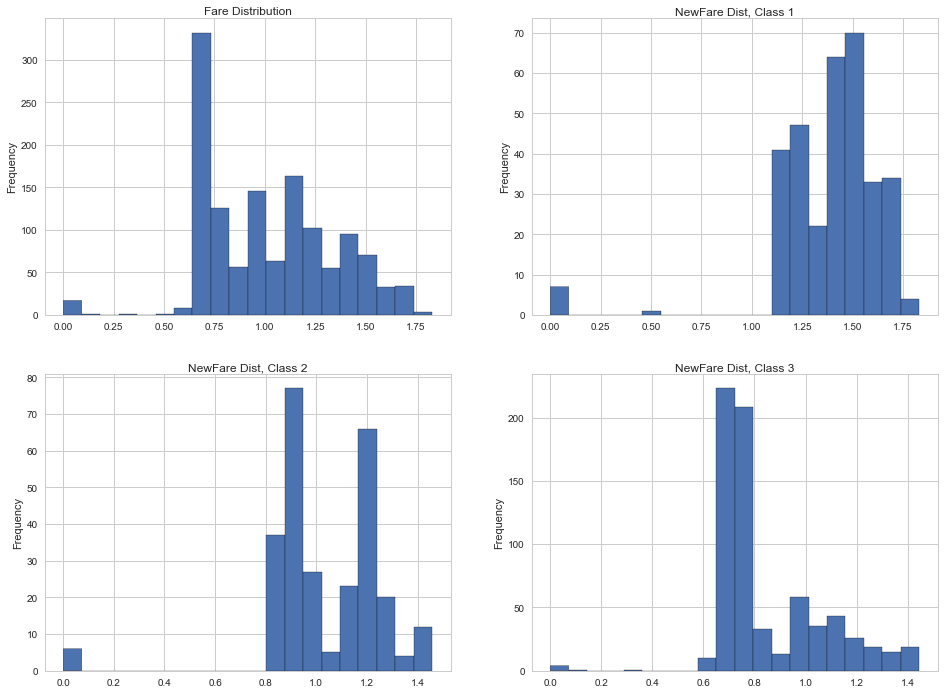

In [13]:
for df in (source_df, assess_df, composite_df):
    df['NewFare'] = df.Fare.apply(lambda x: np.log(np.log(x)) if x else x)

_, axes = plt.subplots(2, 2)
quadrant = [(0,0),(0,1),(1,0),(1,1)]

p = composite_df.NewFare.plot.hist(stacked=True, bins=20, ax=axes[0,0])
p.set_title('Fare Distribution')

for idx, (key, grp) in enumerate(composite_df.groupby(['Pclass'])):
    p = grp.NewFare.plot.hist(stacked=False, bins=20, label=key, ax=axes[quadrant[idx+1][0], quadrant[idx+1][1]])
    p.set_title('NewFare Dist, Class {0}'.format(key))
plt.show()

In [14]:
composite_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,NewAge,NewFare
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,4.690416,0.683603
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,6.164414,1.450832
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,5.099020,0.727559
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,5.916080,1.379314
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,5.916080,0.735091


**Embarked**

In [15]:
for key, grp in composite_df.groupby(['Pclass']):    
    print('Class[{}]: Mode({})'.format(key, grp.Embarked.astype(str).mode()[0]))

for df in (source_df, assess_df):
    for key, grp in df.groupby(['Pclass']):    
        df.loc[(df.Embarked.isnull()) & (df.Pclass == key), 'Embarked'] = composite_df.loc[composite_df.Pclass == key, 'Embarked'].dropna().mode()[0]

Class[1]: Mode(S)
Class[2]: Mode(S)
Class[3]: Mode(S)


The variable Embarked also has one missing value. We're going to replace it with the most common value for its class as well.

We repeat the same for Fare, since fare prices are likely highly correlated to class.

While Class 1 fare prices peak at 500, Class 2 prices peak slightly above 70, and Class 3 prices below that. As with Age, we opt for the medium as a replacement value for the missing ones.

## Exploration

In [16]:
for df in (source_df, assess_df):
    for col in df.keys():
        if col in ('Fare' 'Age'):
            df[col] = df[col].apply(pd.to_numeric)
        elif col in ('Survived', 'Pclass', 'SibSp', 'Parch'):
            df[col] = df[col].astype(np.int64)

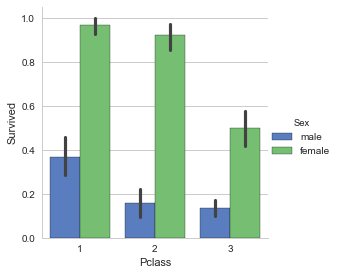

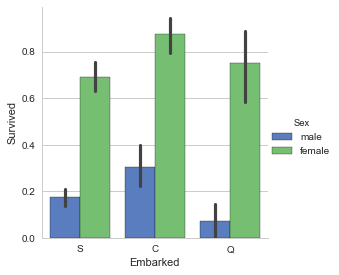

In [17]:
sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=source_df, kind="bar", palette="muted")
sns.factorplot(x='Embarked', y='Survived', hue='Sex', data=source_df, kind="bar", palette="muted")

A passenger's class appears to be one of the highest influencors in determining survival rates. More people from Class 3 died than any other class; this could be a given, since most of the passengers were from Class 3

In [18]:
source_df.groupby('Pclass').size()

Pclass
1    216
2    184
3    491
dtype: int64

Ship's voyage was Belfast, Southmapton, Cherbourg, and Queenstown, with New York as the final destination. Around 80% of the crew members were men from Southampton[[1]](http://www.articlesfactory.com/articles/other/the-roles-of-belfast-southampton-cherbourg-queenstown-and-new-york-in-the-titanic.html), and most passengers did board from that port as well, which explains the higher numbers of people from Southampton compared to the other ports.

Survival rates for women are consistently higher than men. However, there are noticeable differences between survival rates within each sex when measured against tbe port of embarcation and passenger's class, hinting that both might be useful predictors.

To use them in numberic algorithms, we'll each of their values into an independent variable.

In [19]:
testing_passenger_ids = assess_df['PassengerId']
fitnessdf = source_df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
assessmentdf = assess_df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)

for df in (fitnessdf, assessmentdf):
    partners = df.SibSp + df.Parch
    df['FamilySize'] = partners
    df['FamilySize'] *= 1/(df['FamilySize'].max())
#     df['NewAge'] *= 1/composite_df.NewAare.dropna().max()
#     df['NewFare'] *= 1/composite_df.NewFare.dropna().max()
    df['IsYoung'] = df.Age.apply(lambda age: 1 if age < 18 else 0)
    df['LifeStage'] = df.Age.apply(lambda age: 1 if age < 2 else 2 if age < 12 else 3 if age < 18 else 4 if age < 45 else 5)
    df['WithSibSp'] = df.SibSp.apply(lambda sibsp: 1 if sibsp > 0 else 0)
    df['WithParch'] = df.Parch.apply(lambda parch: 1 if parch > 0 else 0)
    
    df['Embarked'] = df.Embarked.map({'S': 1, 'C': 2, 'Q': 3})

    for key in df.Embarked.unique():
        df['{}.{}'.format('Embarked', key)] = df.Embarked.apply(lambda port: 1 if port == key else 0)

#     for key in df.Pclass.unique():
#         df['{}.{}'.format('Pclass', key)] = df.Pclass.apply(lambda cls: 1 if cls == key else 0)

    df.Sex = df.Sex.apply(lambda sex: 1 if sex == 'female' else 0)
    df.drop(['Age', 'Fare'], axis=1, inplace=True)

fitnessdf.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,NewAge,NewFare,FamilySize,IsYoung,LifeStage,WithSibSp,WithParch,Embarked.1,Embarked.2,Embarked.3
0,0,3,0,1,0,1,4.690416,0.683603,0.1,0,4,1,0,1,0,0
1,1,1,1,1,0,2,6.164414,1.450832,0.1,0,4,1,0,0,1,0
2,1,3,1,0,0,1,5.099020,0.727559,0.0,0,4,0,0,1,0,0
3,1,1,1,1,0,1,5.916080,1.379314,0.1,0,4,1,0,1,0,0
4,0,3,0,0,0,1,5.916080,0.735091,0.0,0,4,0,0,1,0,0


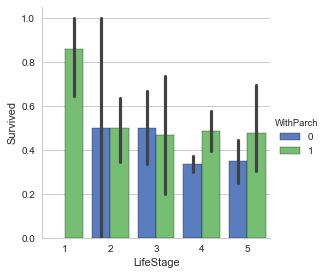

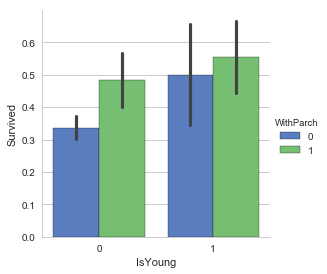

In [20]:
sns.factorplot(x='LifeStage', y='Survived', hue='WithParch', data=fitnessdf, kind="bar", palette="muted")
sns.factorplot(x='IsYoung', y='Survived', hue='WithParch', data=fitnessdf, kind="bar", palette="muted")

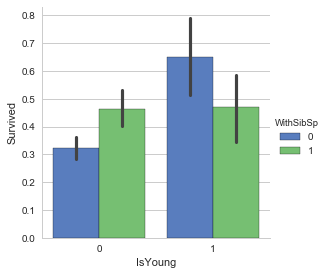

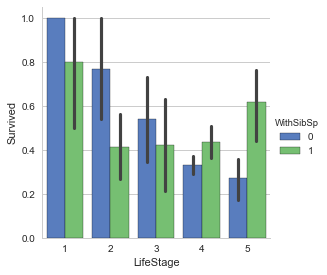

In [21]:
sns.factorplot(x='IsYoung', y='Survived', hue='WithSibSp', data=fitnessdf, kind='bar', palette='muted')
sns.factorplot(x='LifeStage', y='Survived', hue='WithSibSp', data=fitnessdf, kind='bar', palette='muted')

Adults with siblings or spouses are more likely to have survived than those without, and conversely, children without siblings are more likely to have survived than those with.

In [22]:
# fitnessdf.apply(lambda x: sum(pd.isnull(x)))

In [23]:
for df in (fitnessdf, assessmentdf):
#     df.drop(['WithSibSp', 'WithParch', 'LifeStage'], axis=1, inplace=True)
    df.drop(['WithParch', 'LifeStage'], axis=1, inplace=True)
    

In [24]:
#sns.pairplot(fitnessdf.drop([], axis=1), hue='Survived', diag_kind='hist', dropna=True)

While survival rates for women are higher, we musn't forget there were close to twice as many men on the ship compared to women.

In [25]:
ratiof = sum(composite_df.Sex == 'female')/len(composite_df)*100
ratiom = sum(composite_df.Sex == 'male')/len(composite_df)*100
print('Female: {:.2f}%, Male: {:.2f}%'.format(ratiof, ratiom))

Female: 35.60%, Male: 64.40%


However, total survival rate for females is around {_} of the the whole ship, while for men is less than half of that, i.e. roughly {_}. This means that the higher number of female survivors is not solely due to there being less females than males on board.

In [26]:
ratiof = sum((composite_df.Sex == 'female') & (composite_df.Survived == 1))/len(composite_df)*100
ratiom = sum((composite_df.Sex == 'male') & (composite_df.Survived == 1))/len(composite_df)*100
print('Total survival rates')
print('Female: {:.2f}%, Male: {:.2f}%'.format(ratiof, ratiom))

Total survival rates
Female: 17.80%, Male: 8.33%


In [27]:
ratiof = sum((composite_df.Sex == 'female') & (composite_df.Survived == 1))/sum(composite_df.Sex == 'female')*100
ratiom = sum((composite_df.Sex == 'male') & (composite_df.Survived == 1))/sum(composite_df.Sex == 'male')*100
print('In-sex survival rates')
print('Female: {:.2f}%, Male: {:.2f}%'.format(ratiof, ratiom))

In-sex survival rates
Female: 50.00%, Male: 12.93%


Survival rates among females is {_}, and {_} among males. This assumes that the data provided in train.csv is representative of the ship's total data. 

### Dimensionality Reduction

In [28]:
from sklearn.decomposition import PCA

pca, reduced = {}, {}
fitnessval, target = fitnessdf.values[:, 1:], fitnessdf.values[:, 0]
gpca = PCA(whiten=True)
greduced = gpca.fit_transform(fitnessval)
# greduced = gpca.transform(numericdf.values[:, 1:])

In [29]:
gpca.explained_variance_ratio_

array([  3.98055454e-01,   2.16179063e-01,   1.18761563e-01,
         1.01568669e-01,   7.85273545e-02,   3.37523717e-02,
         2.29742982e-02,   1.59485886e-02,   8.82754114e-03,
         5.40509656e-03,   6.26249064e-32,   2.63391954e-32,
         1.39863222e-33])

First 2 components account for close to _

In [30]:
pca_nfactors = 9

## Prediction

We'll try to build a random forest ensemble to try and predict which passengers survived the titanic ship wreck. The ensembles will comprise several decision trees, which in sklearn are based on an [optimised version of the CART algorithm](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms), as of this writing.

**The algorithm allow us to do both classification, and regression. If we were interested in computing the probability of survival, we could use the RandomForestRegressor**


Not all variables in the data set are necessary for our model, so we should drop some of them.

PassengerId is just an indentifier, as are Ticket and Name , and none would add value to our model. Cabin is the location of a passenger's cabin. Perhaps in location-based model it would be useful, provided that we have the knew the positions of each cabin, and assumed passengers in higher cabins had had chances of survival. But we don't, so we discard it.



Since our test data has no outcome variable, we're going to split the training data into three: training, testing, validation. The first to train the model, the second to tune parameters for performance, and the third to run a blind test to verify our model's generalisation. This leaves us with less data for each stage (traning, testing, validation), but hopefully it'll yield better results.

In [31]:
n = len(fitnessdf)
training_indeces = np.random.choice(range(0, n), size=int(n*.65), replace=False)
testing_indeces = np.random.choice([x for x in range(0, n) if x not in training_indeces], size=int(n*.20), replace=False)
validation_indeces = [x for x in range(0, n) if x not in np.concatenate((training_indeces, testing_indeces))]

traindf = fitnessdf.loc[training_indeces][:]
testdf = fitnessdf.loc[testing_indeces][:]
validatedf = fitnessdf.loc[validation_indeces][:]

dataframes = dict(train=traindf, test=testdf, validate=validatedf, assess=assessmentdf)

print('Train[{:.2f}%], Test[{:.2f}%], Validate[{:.2f}%]'.format(len(traindf)/n*100, len(testdf)/n*100, len(validatedf)/n*100))

dataframes['train'].head()

Train[64.98%], Test[19.98%], Validate[15.04%]


,Survived,Pclass,Sex,SibSp,Parch,Embarked,NewAge,NewFare,FamilySize,IsYoung,WithSibSp,Embarked.1,Embarked.2,Embarked.3
725,0,3,0,0,0,1,4.472136,0.769647,0.0,0,0,1,0,0
861,0,2,0,1,0,1,4.582576,0.892959,0.1,0,1,1,0,0
528,0,3,0,0,0,1,6.244998,0.727559,0.0,0,0,1,0,0
46,0,3,0,1,0,3,4.690416,1.008264,0.1,0,1,0,0,1
627,1,1,1,0,0,1,4.582576,1.471594,0.0,0,0,1,0,0


Now, we can build a classifier, and run predictions. The classifiers in sklearn work with numpy arrays, so we need to get the numpy array that corresponds to our DataFrame, and that means we must convert our categorical variables into integers.

Let's make sure we don't have any missing data

In [32]:
for key, df in dataframes.items():
    print('{} missing values count:'.format(key), sum(sum(pd.isnull(df[col])) for col in df.keys()))

assess missing values count: 0
train missing values count: 0
test missing values count: 0
validate missing values count: 0


And fit/train the model

### Random Forest

**Original Data Based Random Forest**

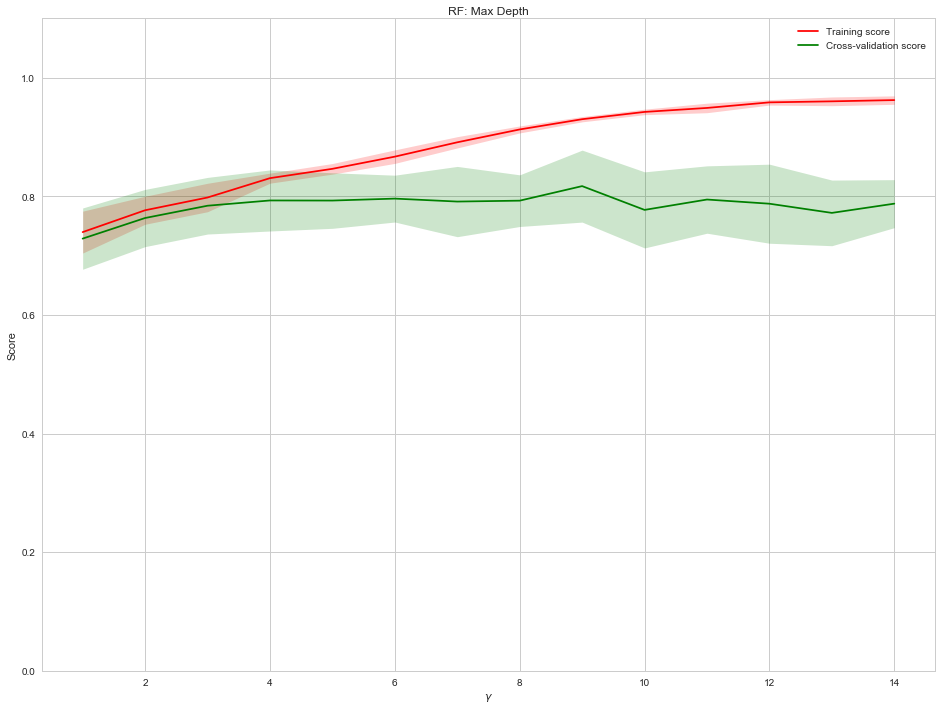

In [33]:
param_range = np.arange(1, 15, 1)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(), 
    traindf.values[0::,1::], 
    traindf.values[0::,0], 
    param_name="max_depth", 
    param_range = param_range, 
    cv=10, 
    scoring="accuracy", 
    n_jobs=-1)
plot_validation_curve(train_scores, test_scores, param_range, log=False, title='RF: Max Depth')

In [34]:
randforest = RandomForestClassifier(n_estimators=11, n_jobs=-1, max_depth=6)
randforest = randforest.fit(traindf.values[0::,1::], traindf.values[0::,0])
randforest.score(traindf.values[0::,1::], traindf.values[0::,0])

0.87392055267702939

Testing performance

In [35]:
randforest.score(testdf.values[0::,1::], testdf.values[0::,0])

0.8258426966292135

Validation performance

In [36]:
randforest.score(validatedf.values[0::,1::], validatedf.values[0::,0])

0.83582089552238803

**PCA Based Random Forest**

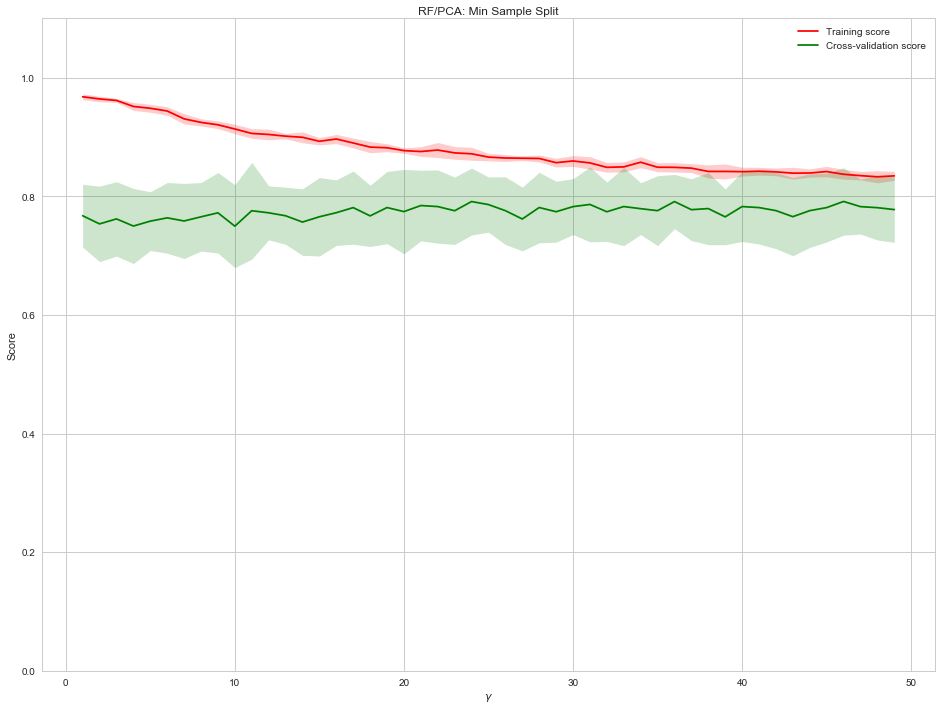

In [37]:
param_range = np.arange(1, 50, 1)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=10), 
    greduced[training_indeces,:pca_nfactors], 
    traindf.values[0::,0], 
    param_name="min_samples_split", 
    param_range = param_range, 
    cv=10, 
    scoring="accuracy", 
    n_jobs=-1)
plot_validation_curve(train_scores, test_scores, param_range, log=False, title='RF/PCA: Min Sample Split')

In [38]:
randforestRed = RandomForestClassifier(n_estimators=10, n_jobs=-1, min_samples_split=30)
randforestRed = randforestRed.fit(greduced[training_indeces,:pca_nfactors], traindf.values[0::,0])
randforestRed.score(greduced[training_indeces,:pca_nfactors], traindf.values[0::,0])

0.85664939550949915

Testing performance

In [39]:
randforestRed.score(greduced[testing_indeces,:pca_nfactors], testdf.values[0::,0])

0.8089887640449438

Validation performance

In [40]:
randforestRed.score(greduced[validation_indeces,:pca_nfactors], validatedf.values[0::,0])

0.82835820895522383

### SVM

**Original Data Based SVM**

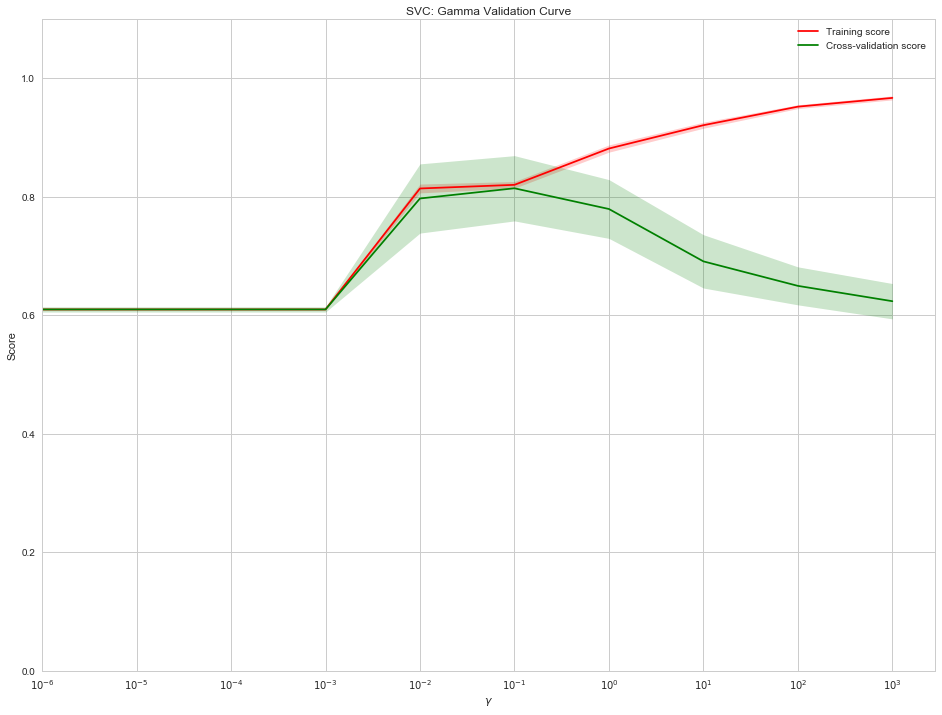

In [41]:
param_range = np.logspace(-6, 3, 10)

train_scores, test_scores = validation_curve(
    svm.SVC(kernel='rbf', probability=True), 
    traindf.values[:,1::], 
    traindf.values[0::,0], 
    param_name='gamma', 
    param_range = param_range, 
    cv=10, 
    scoring="accuracy", 
    n_jobs=-1)
plot_validation_curve(train_scores, test_scores, param_range, title='SVC: Gamma Validation Curve', log=True)

In [42]:
from sklearn import svm

smvc = svm.SVC(kernel='rbf', gamma=10**-1, probability=True)
smvc.fit(traindf.values[0::,1::], traindf.values[0::,0])
smvc.score(traindf.values[0::,1::], traindf.values[0::,0])

0.82037996545768566

Testing Performance

In [43]:
smvc.score(testdf.values[0::,1::], testdf.values[0::,0])

0.848314606741573

Validation Performance

In [44]:
smvc.score(validatedf.values[0::,1::], validatedf.values[0::,0])

0.84328358208955223

**PCA Based SVM**

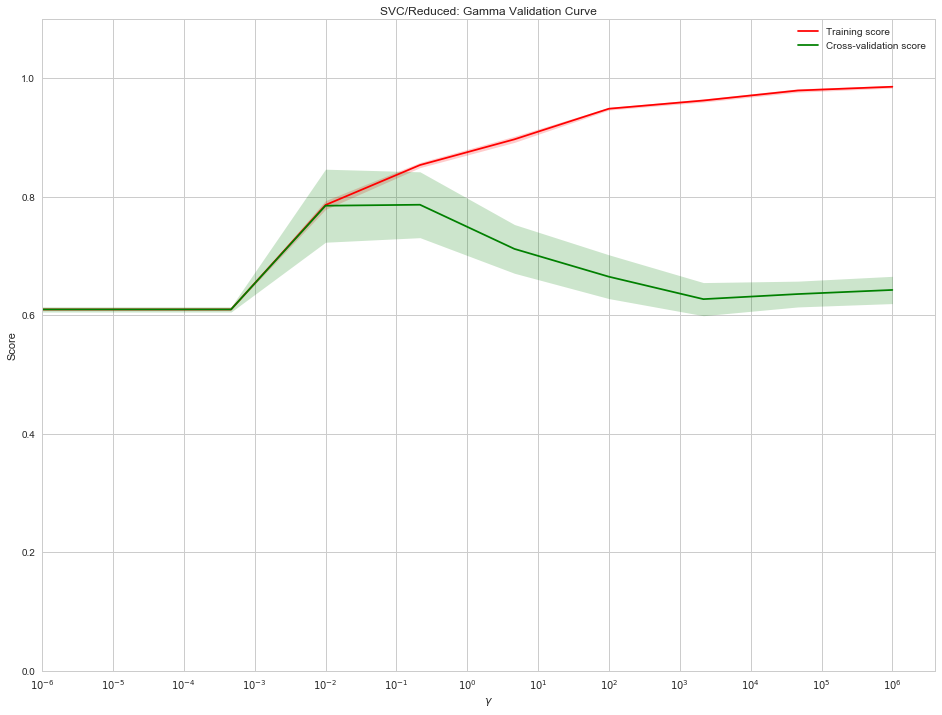

In [45]:
param_range = np.logspace(-6, 6, 10)
train_scores, test_scores = validation_curve(
    svm.SVC(probability=True), 
    greduced[training_indeces,:pca_nfactors], 
    traindf.values[0::,0], 
    param_name='gamma', 
    param_range = param_range, 
    cv=10, 
    scoring='accuracy', 
    n_jobs=-1)
plot_validation_curve(train_scores, test_scores, param_range, title='SVC/Reduced: Gamma Validation Curve', log=True)

In [66]:
from sklearn import svm

smvcRed = svm.SVC(gamma=10**-1)
smvcRed.fit(greduced[training_indeces,:pca_nfactors], traindf.values[0::,0])
smvcRed.score(greduced[training_indeces,:pca_nfactors], traindf.values[0::,0])

0.78583765112262527

In [47]:
smvcRed.score(greduced[testing_indeces,:pca_nfactors], testdf.values[0::,0])

0.8370786516853933

In [48]:
smvcRed.score(greduced[validation_indeces,:pca_nfactors], validatedf.values[0::,0])

0.83582089552238803

**Neural Network**

In [58]:
nn = sknn.mlp.Classifier(
    layers=[
        sknn.mlp.Layer("Tanh", units=10),
        sknn.mlp.Layer("Tanh", units=10),
        sknn.mlp.Layer("Softmax")],
    learning_rate=0.01,
    n_iter=300)

nn.fit(traindf.values[0::,1::], traindf.values[0::,0])
nn.score(traindf.values[0::,1::], traindf.values[0::,0])

[(579, 2)]


0.81174438687392059

In [59]:
nn.score(testdf.values[0::,1::], testdf.values[0::,0])


[(178, 2)]


0.848314606741573

In [60]:
nn.score(validatedf.values[0::,1::], validatedf.values[0::,0])

[(134, 2)]


0.81343283582089554

**Logistic Regression**

In [61]:
# param_range = np.arange(50, 300)
# train_scores, test_scores = validation_curve(
#     LogisticRegression(solver='liblinear', tol=10**-8, dual=False, n_jobs=-1), 
#     greduced[training_indeces,:5], traindf.values[0::,0], 
#     param_name="max_iter", 
#     param_range = param_range, 
#     cv=10, 
#     scoring="accuracy", 
#     n_jobs=-1)
# plot_validation_curve(train_scores, test_scores, param_range, title='Logistic Regression: C', log=False)

In [62]:
logreg = LogisticRegression(solver='lbfgs', tol=10**-8, n_jobs=-1)
logreg.fit(traindf.values[0::,1::], traindf.values[0::,0])
logreg.score(traindf.values[0::,1::], traindf.values[0::,0])

0.81347150259067358

In [63]:
logreg.score(testdf.values[0::,1::], testdf.values[0::,0])

0.8314606741573034

In [64]:
logreg.score(validatedf.values[0::,1::], validatedf.values[0::,0])

0.83582089552238803

### Save results

In [65]:
models = {'rf': randforest, 'rfpca': randforestRed, 'svm': smvc, 'svmpca': smvcRed, 'nn': nn, 'logreg': logreg}

for k, m in models.items():
    if k.endswith('pca'):
        pca = PCA(whiten=True)
        data = pca.fit_transform(assessmentdf.values[:,:])
        data = data[:,:pca_nfactors]
    else:
        data = assessmentdf.values[:,:]
    
    predictions = m.predict(data)
    
    if k is 'nn':
        predictions = [int(x[0]) for x in predictions]
    else:
        predictions = predictions.astype(int)
    
    with open('predictions-{}.csv'.format(k), 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['PassengerId', 'Survived'])

        for idx, val in zip(testing_passenger_ids, predictions):
            writer.writerow([idx, val])
    

[(418, 2)]
